# Tutorial 3a. Homemade one-hidden layer perceptron for binary classification

![](mlp.svg)

## This is a homework: put your names here

- `Adrien Akar`
- `Guilhem Bonnieu`

## Description

The goal of this tutorial is to build and train your first neural network *by hand* !

- To keep things as simple as possible we consider a simple *perceptron* with *one hidden layer*
- We consider a binary-classification problem which cannot be solved with a linear classifier
- We use a toy dataset which is already created for you with the `load_data()` function

The neural network will have to be **programmed and trained from scratch**, meaning that you will have to define its structure yourself, and that **you are not allowed** to use the built-in functionalities of `PyTorch` for autodifferentiation. You will have to program the forward and backward pass *yourself*, together with the gradient descent algorithm.

**Read the following instructions carefully in order to succeed**

- You are already provided with a simple python class which will constitute your neural network. 

- The constructor of this class (`__init__`) requires you to specify the following parameters (investigate the data carefully in order to know how these parameters need to be defined).
    - Number of input nodes (number of features)
    - Number of hidden units 
    - Number of output nodes

- The constructor of the neural network also requires you to allocate the weight matrices and bias vectors which will be the main components of your computational graph. For this, you can use some of the tensor operations we have seen in `tutorial2a`, in order to initialize at random the weights, for instance.

- Implementing a neural network consists in two main steps:
    - Forward-pass: computing the output of the network based on its weight matrices and bias vectors. Since we consider binary classification, we should output activations that are activated by a sigmoid
    - Backward-pass: computing how different the predictions of the network are from what should be predicted and update the parameters of the network with the backpropagation algorithm. You are already provided with a loss function in the code which requires only slight modifications.

- If you want to challenge yourself you can extend the neural network as follows:
    - add multiple hidden layers of different sizes
    - explore different non-linear activation functions
    - investigate whether the network starts overfitting

In [53]:
import numpy as np
import torch
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, roc_auc_score)

## Simulation of the data

In [2]:
def load_data(n_samples=500):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=n_samples,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

In [3]:
gaussian_quantiles = load_data()
X, y = gaussian_quantiles

print(X[:10, :])
print(y[:10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=87)

[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


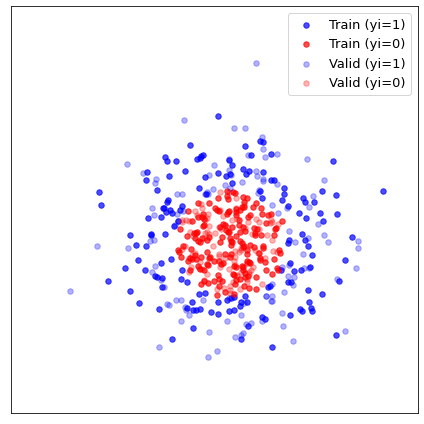

In [4]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha=0.7, label="Train")
plot_data(X_test, y_test, alpha=0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()

## A neural network class

**QUESTION.** Implement the `forward` and `backward` methods in the following class, and fill the `__init__` and `train` methods, in order to train the one-hidden layer perceptron for binary classification. 

In [5]:
class NeuralNetwork:
    def __init__(self, n_in, n_hidden, n_out):
        # number of input nodes
        self.n_x = n_in
        # number of hidden nodes
        self.n_h = n_hidden
        # number of output nodes
        self.n_y = n_out
        # Define 1st weight matrix (using random initialization)
        self.W1 = torch.rand((n_hidden,n_in))
        # define 1st bias vector
        self.b1 = torch.rand((n_hidden,1))
        # Define 2nd weight matrix (using random initialization)
        self.W2 = torch.rand((n_out,n_hidden))
        # Define 2nd bias vector
        self.b2 = torch.rand((n_out,1))
        # error in the sigmoid function not to compute log(0)
        self.epsilon=0.0000000000000000001    
   
        self.epochs=[]
        self.train_results=[]
        self.valid_results=[]
        self.train_acc=[]
        self.valid_acc=[]

    def results(self):
      return (self.train_results,self.valid_results)


    def forward(self, X):

      self.X1=torch.nn.functional.relu(torch.matmul(self.W1,X.t())+torch.matmul(self.b1,torch.ones((1,len(X)))))
      self.X2=torch.sigmoid(torch.matmul(self.W2,self.X1)+torch.matmul(self.b2,torch.ones((self.n_y,len(X)))))

        
    def backward(self, X, y):

      m = X.shape[0]

      self.grad_w1=torch.matmul(torch.matmul((self.X2-y).t(), self.W2).t()*torch.sign(self.X1),X)/m
      self.grad_b1=torch.sum(torch.matmul((self.X2-y).t(), self.W2).t()*torch.sign(self.X1),1).unsqueeze(0).t()/m
      self.grad_w2=torch.matmul((self.X2-y),self.X1.t())/m
      self.grad_b2=torch.sum((self.X2-y).t(),0)/m
      

        
    def train(self, X_train, y_train, X_valid, y_valid, epochs, learning_rate):
        m_train = X_train.shape[0]
        m_valid= X_valid.shape[0]
        for e in range(epochs):
            
            self.forward(X_train)
            #epsilon is added to prevent computing the log of 0
            training_loss = -(torch.dot(y_train,torch.log(self.X2[0]+self.epsilon))+torch.dot(torch.log(1-self.X2[0] +self.epsilon),  (1 - y_train)))/m_train
            self.backward(X_train,y_train)
            
            self.forward(X_valid)
            validation_loss=-(torch.dot(y_valid,torch.log(self.X2+self.epsilon)[0])+torch.dot(torch.log(1-self.X2 +self.epsilon)[0],  (1 - y_valid)))/m_valid
            
            print("training_loss :"+str(training_loss.item()),"validation_loss :"+ str(validation_loss.item()))

            self.epochs.append(e)
            self.train_results.append(training_loss.item())
            self.valid_results.append(validation_loss.item())
            self.train_acc.append(self.accuracy(m_train,X_train,y_train))
            self.valid_acc.append(self.accuracy(m_valid,X_valid,y_valid))


            self.W1 -= learning_rate*self.grad_w1 # update of the 1st weight matrix
            self.b1 -= learning_rate*self.grad_b1 # update of the 1st bias vector
            self.W2 -= learning_rate*self.grad_w2 # update of the 2nd weight matrix
            self.b2 -= learning_rate*self.grad_b2 # update of the 2nd bias vector

    def predict_proba(self,X):
      self.forward(X)
      return self.X2
    
    def accuracy(self,m,X,y):
      self.forward(X)
      binary_y=torch.round(self.X2)
      acc=0
      for i in range(len(y)):
        if binary_y[0][i]==y[i]:
          acc+=1
      return acc/m

**QUESTION.** Train your neural network, modify your code to save the training and validation error along the gradient descent iterations and plot them. You should also print the train and validation errors during training.

In [6]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()
X_valid_torch = torch.from_numpy(X_test).float()
y_valid_torch = torch.from_numpy(y_test).float()



**QUESTION.** Use and modify the plotting functions from this notebook and the ones from `tutorial01` in order to plot the data together with the **predicted probabilities** of your neural network for inputs in a grid covering the input features space (as we did in `tutorial01`). Also, display on the plot the AUC-ROC metric obtained by your neural net.

In [26]:


def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

def plot_data(ax, X, y, xy_labels=True, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=r"$y_i=1$", **kwargs)
    plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=r"$y_i=-1$", **kwargs)
    ax.set_xticks(())
    ax.set_yticks(())
    if xy_labels:
        ax.set_xlabel(r"$x_{i,1}$", fontsize=15)
        ax.set_ylabel(r"$x_{i,2}$", fontsize=15)
    ax.set_xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    ax.set_ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

def plot_probas(nn, ax, X, y, h=0.02, levels=20, colorbar=True):
    x_min, x_max = X[:, 0].min() - .005, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))    
    Z = nn.predict_proba(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type('torch.FloatTensor')).numpy()[0,:]
    Z = Z.reshape(xx.shape)
    ct = ax.contourf(xx, yy, Z, cmap=cm, alpha=.7, levels=levels)
    if colorbar:
        cbar = plt.colorbar(ct)
        cbar.ax.set_xlabel(r"$\sigma(x \cdot w + b)$")
    

<Figure size 720x720 with 0 Axes>

In [45]:
def plot_roc_curve(y_test, y_score, title=None, label=None, legend=True, 
                   show_thresholds=True, colorbar=True):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    thresholds[0] = 1
    roc_auc = roc_auc_score(y_test, y_score)

    if label is None:
        label='ROC curve (area = %0.2f)' % roc_auc

    if title is None:
        title = "ROC curve"

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    
    if show_thresholds:
        norm = plt.Normalize(vmin=0, vmax=1)
        plt.plot(fpr, tpr, lw=1, label=label, alpha=0.7)
        plt.scatter(fpr, tpr, cmap=cm, c=thresholds, s=70, norm=norm)
        if colorbar:
            plt.colorbar()
    else:
        plt.plot(fpr, tpr, lw=3, label=label)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(title, fontsize=16)
    if legend:
        plt.legend(fontsize=12)

def plot_roc_curves(y_test, y_scores, labels, title=None, show_thresholds=True):
    for y_score, label in zip(y_scores, labels):
        plot_roc_curve(y_test, y_score, label=label, legend=False, 
                       show_thresholds=show_thresholds, colorbar=False)
    plt.legend(fontsize=12)
    if show_thresholds:
        plt.colorbar()
    if title is not None:
        plt.title(title, fontsize=16)        

### Neural network with 2 neurones in the hidden layer

In [48]:
nn2 = NeuralNetwork(2, 2, 1)

nn2.train(
    X_train_torch,
    y_train_torch,
    X_valid_torch,
    y_valid_torch,
    epochs=2000,
    learning_rate=0.05
)

training_loss :0.7810170650482178 validation_loss :0.728594958782196
training_loss :0.7767757177352905 validation_loss :0.7257684469223022
training_loss :0.7727530002593994 validation_loss :0.723116934299469
training_loss :0.768936038017273 validation_loss :0.720629096031189
training_loss :0.7653127908706665 validation_loss :0.7182946801185608
training_loss :0.7618719339370728 validation_loss :0.7161041498184204
training_loss :0.7586029767990112 validation_loss :0.7140481472015381
training_loss :0.7554960250854492 validation_loss :0.7121185064315796
training_loss :0.7525418400764465 validation_loss :0.7103073000907898
training_loss :0.7497319579124451 validation_loss :0.7086071968078613
training_loss :0.7470579743385315 validation_loss :0.7070112824440002
training_loss :0.7445125579833984 validation_loss :0.7055131793022156
training_loss :0.7420884966850281 validation_loss :0.7041069269180298
training_loss :0.7397792339324951 validation_loss :0.7027868628501892
training_loss :0.7375783

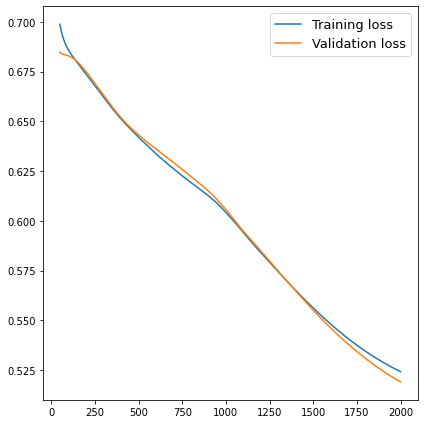

In [49]:
first_epoch=50
plt.figure(figsize=(6, 6))
plt.plot(nn2.epochs[first_epoch:],nn2.train_results[first_epoch:], label="Training loss")
plt.plot(nn2.epochs[first_epoch:],nn2.valid_results[first_epoch:], label="Validation loss")
plt.legend(fontsize=13)
plt.tight_layout()

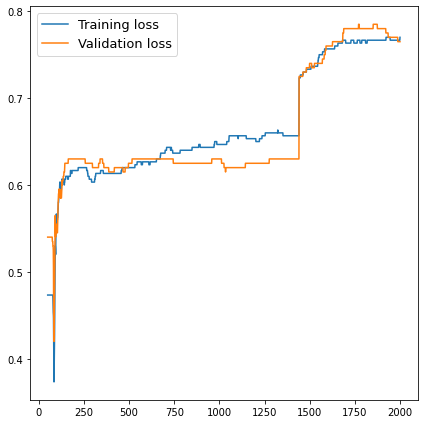

In [50]:
first_epoch=50
plt.figure(figsize=(6, 6))
plt.plot(nn2.epochs[first_epoch:],nn2.train_acc[first_epoch:], label="Training loss")
plt.plot(nn2.epochs[first_epoch:],nn2.valid_acc[first_epoch:], label="Validation loss")
plt.legend(fontsize=13)
plt.tight_layout()

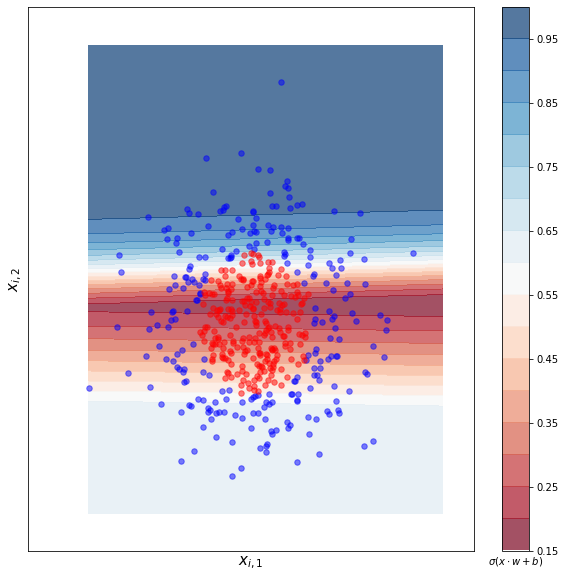

In [51]:

plt.figure(figsize=(10, 10))
h = 0.02
levels = 20

ax=plt.subplot(1,1,1)
plot_probas(nn2, ax, X, y, h=h, levels=levels)
plot_data(ax, X, y, alpha=0.5)



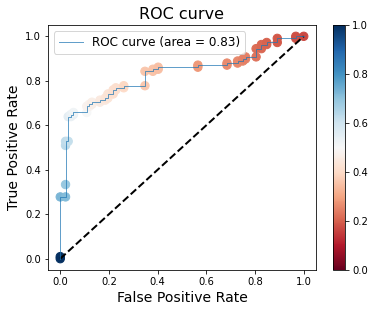

In [54]:
y_score=nn2.predict_proba(X_valid_torch).numpy()[0,:]
plt.figure(figsize=(6, 4.5))
plot_roc_curve(y_test, y_score)

### Neural network with 4 neurones in the hidden layer


In [55]:
nn4 = NeuralNetwork(2, 4, 1)

nn4.train(
    X_train_torch,
    y_train_torch,
    X_valid_torch,
    y_valid_torch,
    epochs=2000,
    learning_rate=0.05
)

training_loss :1.283048152923584 validation_loss :1.0901949405670166
training_loss :1.23981511592865 validation_loss :1.0551360845565796
training_loss :1.1994553804397583 validation_loss :1.0225956439971924
training_loss :1.1618143320083618 validation_loss :0.9924419522285461
training_loss :1.1267268657684326 validation_loss :0.9644711017608643
training_loss :1.0940470695495605 validation_loss :0.938525915145874
training_loss :1.063697338104248 validation_loss :0.9145251512527466
training_loss :1.0355074405670166 validation_loss :0.8923530578613281
training_loss :1.0092649459838867 validation_loss :0.8718739151954651
training_loss :0.9848816990852356 validation_loss :0.8529646992683411
training_loss :0.9622229933738708 validation_loss :0.8355334401130676
training_loss :0.9411390423774719 validation_loss :0.8194350600242615
training_loss :0.9215474724769592 validation_loss :0.804608941078186
training_loss :0.903364896774292 validation_loss :0.7909960746765137
training_loss :0.8865020871

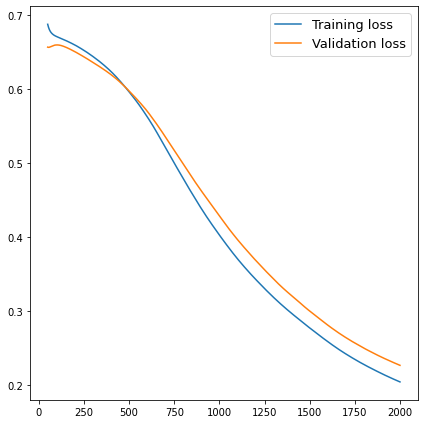

In [56]:
first_epoch=50
plt.figure(figsize=(6, 6))
plt.plot(nn4.epochs[first_epoch:],nn4.train_results[first_epoch:], label="Training loss")
plt.plot(nn4.epochs[first_epoch:],nn4.valid_results[first_epoch:], label="Validation loss")
plt.legend(fontsize=13)
plt.tight_layout()

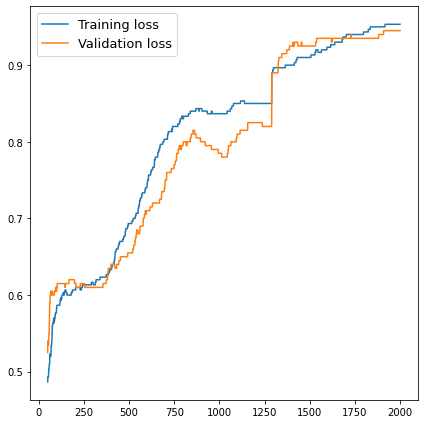

In [57]:
first_epoch=50
plt.figure(figsize=(6, 6))
plt.plot(nn4.epochs[first_epoch:],nn4.train_acc[first_epoch:], label="Training loss")
plt.plot(nn4.epochs[first_epoch:],nn4.valid_acc[first_epoch:], label="Validation loss")
plt.legend(fontsize=13)
plt.tight_layout()

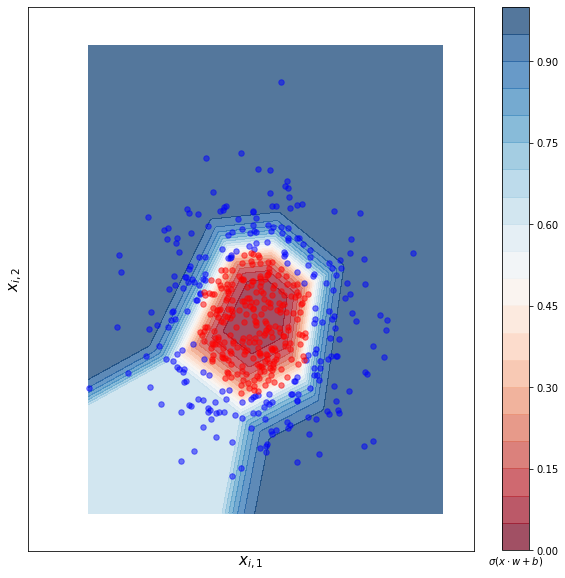

In [58]:

plt.figure(figsize=(10, 10))
h = 0.02
levels = 20

ax=plt.subplot(1,1,1)
plot_probas(nn4, ax, X, y, h=h, levels=levels)
plot_data(ax, X, y, alpha=0.5)

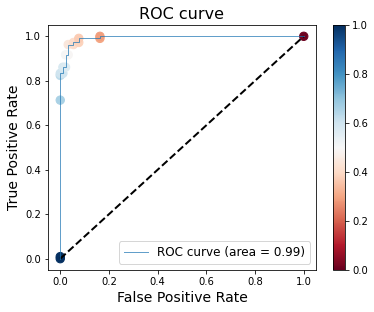

In [59]:
y_score=nn4.predict_proba(X_valid_torch).numpy()[0,:]
plt.figure(figsize=(6, 4.5))
plot_roc_curve(y_test, y_score)

### Neural network with 10 neurones in the hidden layer

In [65]:
nn10 = NeuralNetwork(2, 10, 1)

nn10.train(
    X_train_torch,
    y_train_torch,
    X_valid_torch,
    y_valid_torch,
    epochs=2000,
    learning_rate=0.05
)

training_loss :2.14298939704895 validation_loss :1.7848329544067383
training_loss :2.0448358058929443 validation_loss :1.703104853630066
training_loss :1.9519391059875488 validation_loss :1.6258991956710815
training_loss :1.86400306224823 validation_loss :1.5531245470046997
training_loss :1.7806966304779053 validation_loss :1.484409213066101
training_loss :1.7020001411437988 validation_loss :1.4196465015411377
training_loss :1.6278295516967773 validation_loss :1.3585975170135498
training_loss :1.5582244396209717 validation_loss :1.3012900352478027
training_loss :1.492655873298645 validation_loss :1.2473952770233154
training_loss :1.4307656288146973 validation_loss :1.1967207193374634
training_loss :1.3723623752593994 validation_loss :1.1491104364395142
training_loss :1.3171842098236084 validation_loss :1.104367971420288
training_loss :1.2651474475860596 validation_loss :1.062340497970581
training_loss :1.2161558866500854 validation_loss :1.0229541063308716
training_loss :1.170014142990

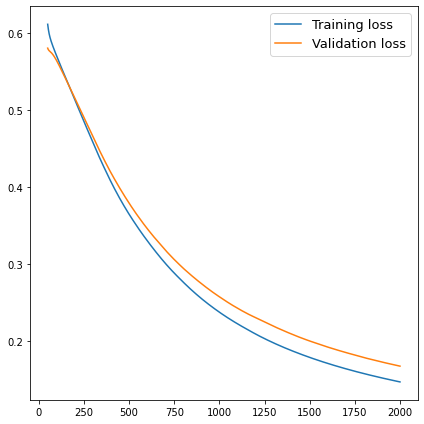

In [66]:
first_epoch=50
plt.figure(figsize=(6, 6))
plt.plot(nn10.epochs[first_epoch:],nn10.train_results[first_epoch:], label="Training loss")
plt.plot(nn10.epochs[first_epoch:],nn10.valid_results[first_epoch:], label="Validation loss")
plt.legend(fontsize=13)
plt.tight_layout()

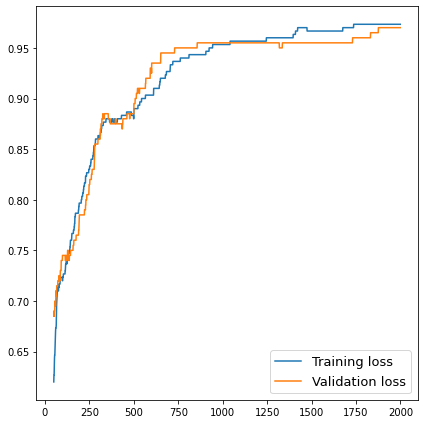

In [67]:
first_epoch=50
plt.figure(figsize=(6, 6))
plt.plot(nn10.epochs[first_epoch:],nn10.train_acc[first_epoch:], label="Training loss")
plt.plot(nn10.epochs[first_epoch:],nn10.valid_acc[first_epoch:], label="Validation loss")
plt.legend(fontsize=13)
plt.tight_layout()

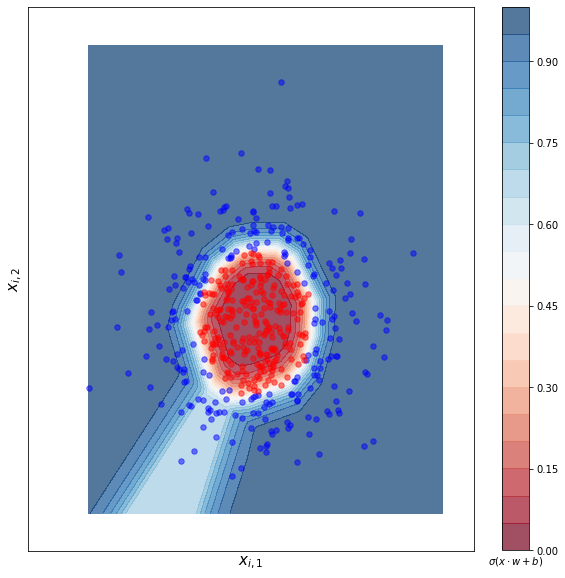

In [68]:

plt.figure(figsize=(10, 10))
h = 0.02
levels = 20

ax=plt.subplot(1,1,1)
plot_probas(nn10, ax, X, y, h=h, levels=levels)
plot_data(ax, X, y, alpha=0.5)

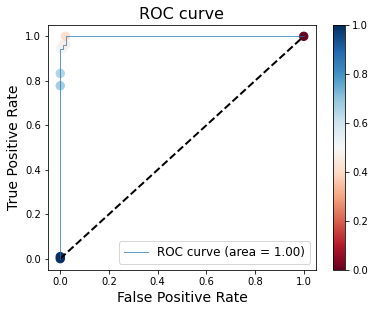

In [69]:
y_score=nn10.predict_proba(X_valid_torch).numpy()[0,:]
plt.figure(figsize=(6, 4.5))
plot_roc_curve(y_test, y_score)

### Neural network with 100 neurones in the hidden layer

In [70]:
nn100 = NeuralNetwork(2, 100, 1)

nn100.train(
    X_train_torch,
    y_train_torch,
    X_valid_torch,
    y_valid_torch,
    epochs=2000,
    learning_rate=0.05
)

training_loss :16.585357666015625 validation_loss :13.91594123840332
training_loss :15.969703674316406 validation_loss :13.205998420715332
training_loss :15.34103012084961 validation_loss :12.754467964172363
training_loss :14.890938758850098 validation_loss :12.303485870361328
training_loss :14.43563461303711 validation_loss :11.157146453857422
training_loss :13.802881240844727 validation_loss :10.402327537536621
training_loss :13.253052711486816 validation_loss :9.624555587768555
training_loss :12.694299697875977 validation_loss :8.990230560302734
training_loss :11.85684871673584 validation_loss :8.484186172485352
training_loss :11.09561824798584 validation_loss :8.261366844177246
training_loss :10.323294639587402 validation_loss :8.046009063720703
training_loss :9.635478973388672 validation_loss :7.1461710929870605
training_loss :9.12082290649414 validation_loss :6.784533500671387
training_loss :8.330260276794434 validation_loss :6.2884039878845215
training_loss :7.528536796569824 va

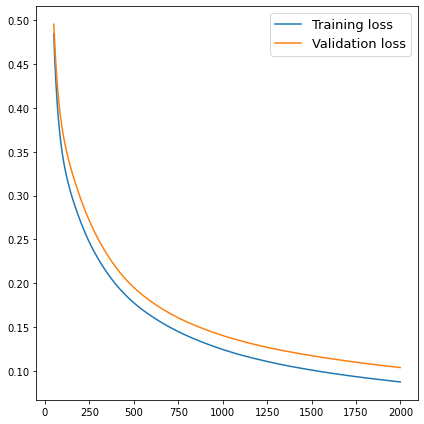

In [71]:
first_epoch=50
plt.figure(figsize=(6, 6))
plt.plot(nn100.epochs[first_epoch:],nn100.train_results[first_epoch:], label="Training loss")
plt.plot(nn100.epochs[first_epoch:],nn100.valid_results[first_epoch:], label="Validation loss")
plt.legend(fontsize=13)
plt.tight_layout()

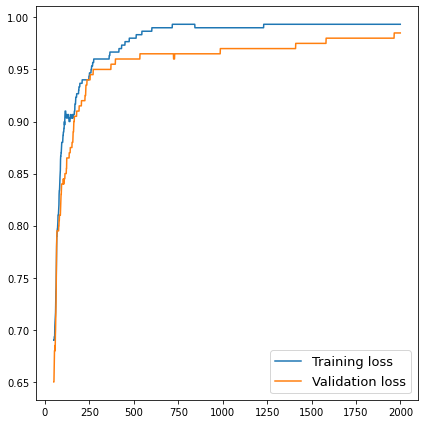

In [72]:
first_epoch=50
plt.figure(figsize=(6, 6))
plt.plot(nn100.epochs[first_epoch:],nn100.train_acc[first_epoch:], label="Training loss")
plt.plot(nn100.epochs[first_epoch:],nn100.valid_acc[first_epoch:], label="Validation loss")
plt.legend(fontsize=13)
plt.tight_layout()

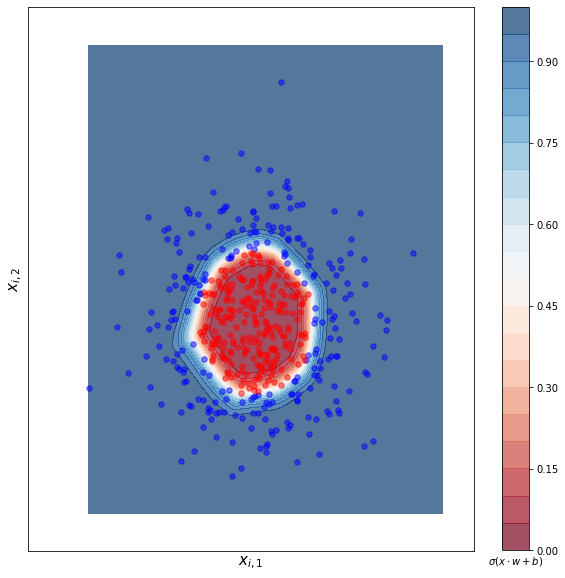

In [73]:

plt.figure(figsize=(10, 10))
h = 0.02
levels = 20

ax=plt.subplot(1,1,1)
plot_probas(nn100, ax, X, y, h=h, levels=levels)
plot_data(ax, X, y, alpha=0.5)

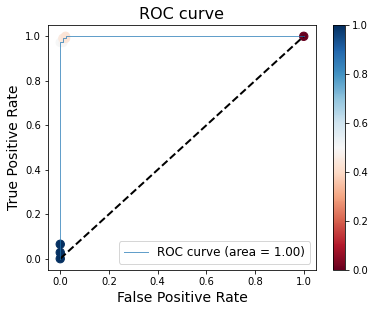

In [74]:
y_score=nn100.predict_proba(X_valid_torch).numpy()[0,:]
plt.figure(figsize=(6, 4.5))
plot_roc_curve(y_test, y_score)